# Sequence Model with Attention (Matthew McAteer)


- This is **many-to-one** sequence model.
- Matthew McAteer's [Getting started with Attention for Classification: A quick guide on how to start using Attention in your NLP models](https://matthewmcateer.me/blog/getting-started-with-attention-for-classification/)

- This tutorial demonstrates a bi-directional LSTM sequence on sentiment analysis (binary classification). The key is to add Attention layer to make use of all output states from the bi-directional LSTMs. (Traditional LSTMs use only the final encoded state of the RNN for a prediction task.
- The conundrum with RNNs/LSTMs is that they are not good at dealing with dependencies and relevant relationships in the previous steps of the sequences.

In [3]:
from importlib import  reload
import sys
from imp import  reload
import warnings
warnings.filterwarnings('ignore')
# if sys.version[0] == '2':
#     reload(sys)
# sys.setdefaultencoding("utf-8")
  
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
  
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [10]:
import pandas as pd
  
df = pd.read_csv('../../../RepositoryData/data/IMDB/labeledTrainData.tsv', delimiter="\t")
df = df.drop(['id'], axis=1)
# df['sentiment'] = df['sentiment'].map({'pos': 1, 'neg': 0})

df.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [11]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
  
 
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if  not word in stop_words]
    text = " ".join(text)
    return text
  
df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))
df.head()

,sentiment,review,Processed_Reviews
0,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [12]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

129.54916

In [13]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])
  
RNN_CELL_SIZE = 32
  
MAX_LEN = 130  # Since our mean length is 128.5
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = df['sentiment']

In [14]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [15]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [16]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [17]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

In [20]:
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 130, 128)     768000      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 130, 64)      41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 130, 64), (N 24832       bi_lstm_0[0][0]                  
______________________________________________________________________________________________

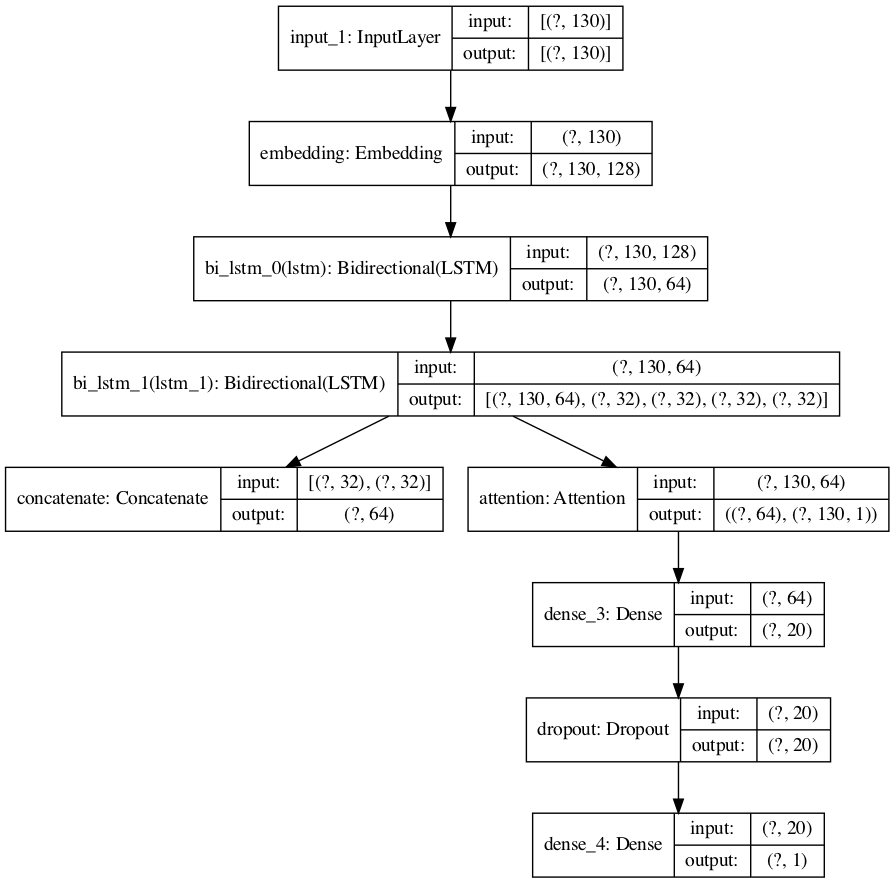

In [19]:
keras.utils.plot_model(model, show_shapes=True, dpi = 100)

In [21]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

In [22]:
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/5
200/200 [==============================] - 48s 239ms/step - loss: 0.4054 - tp: 7530.0000 - fp: 1399.0000 - tn: 8629.0000 - fn: 2442.0000 - accuracy: 0.8080 - precision: 0.8433 - recall: 0.7551 - auc: 0.8971 - val_loss: 0.3101 - val_tp: 2195.0000 - val_fp: 327.0000 - val_tn: 2145.0000 - val_fn: 333.0000 - val_accuracy: 0.8680 - val_precision: 0.8703 - val_recall: 0.8683 - val_auc: 0.9415
Epoch 2/5
200/200 [==============================] - 45s 223ms/step - loss: 0.2312 - tp: 9116.0000 - fp: 931.0000 - tn: 9097.0000 - fn: 856.0000 - accuracy: 0.9107 - precision: 0.9073 - recall: 0.9142 - auc: 0.9665 - val_loss: 0.3227 - val_tp: 2123.0000 - val_fp: 243.0000 - val_tn: 2229.0000 - val_fn: 405.0000 - val_accuracy: 0.8704 - val_precision: 0.8973 - val_recall: 0.8398 - val_auc: 0.9444
Epoch 3/5
200/200 [==============================] - 43s 217ms/step - loss: 0.1689 - tp: 9378.0000 - fp: 642.0000 - tn: 9386.0000 - fn: 594.0000 - accuracy: 0.9382 - precision: 0.9359 - recall: 0.9404 -

In [23]:
# Loading the test dataset, and repeating the processing steps
df_test=pd.read_csv("../../../RepositoryData/data/IMDB/testData.tsv",header=0, delimiter="\t", quoting=3)
df_test.head()
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1  if  int(x.strip('"').split("_")[1]) >= 5  else  0)
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)
  
## Making predictions on our model
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     12500
           1       0.86      0.83      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



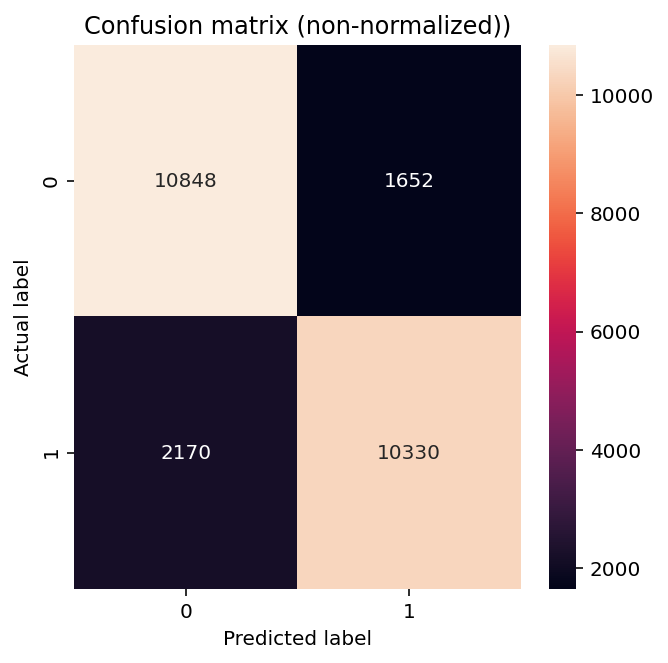

In [24]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(y_test, y_pred)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
  
plot_cm(y_test, y_pred)

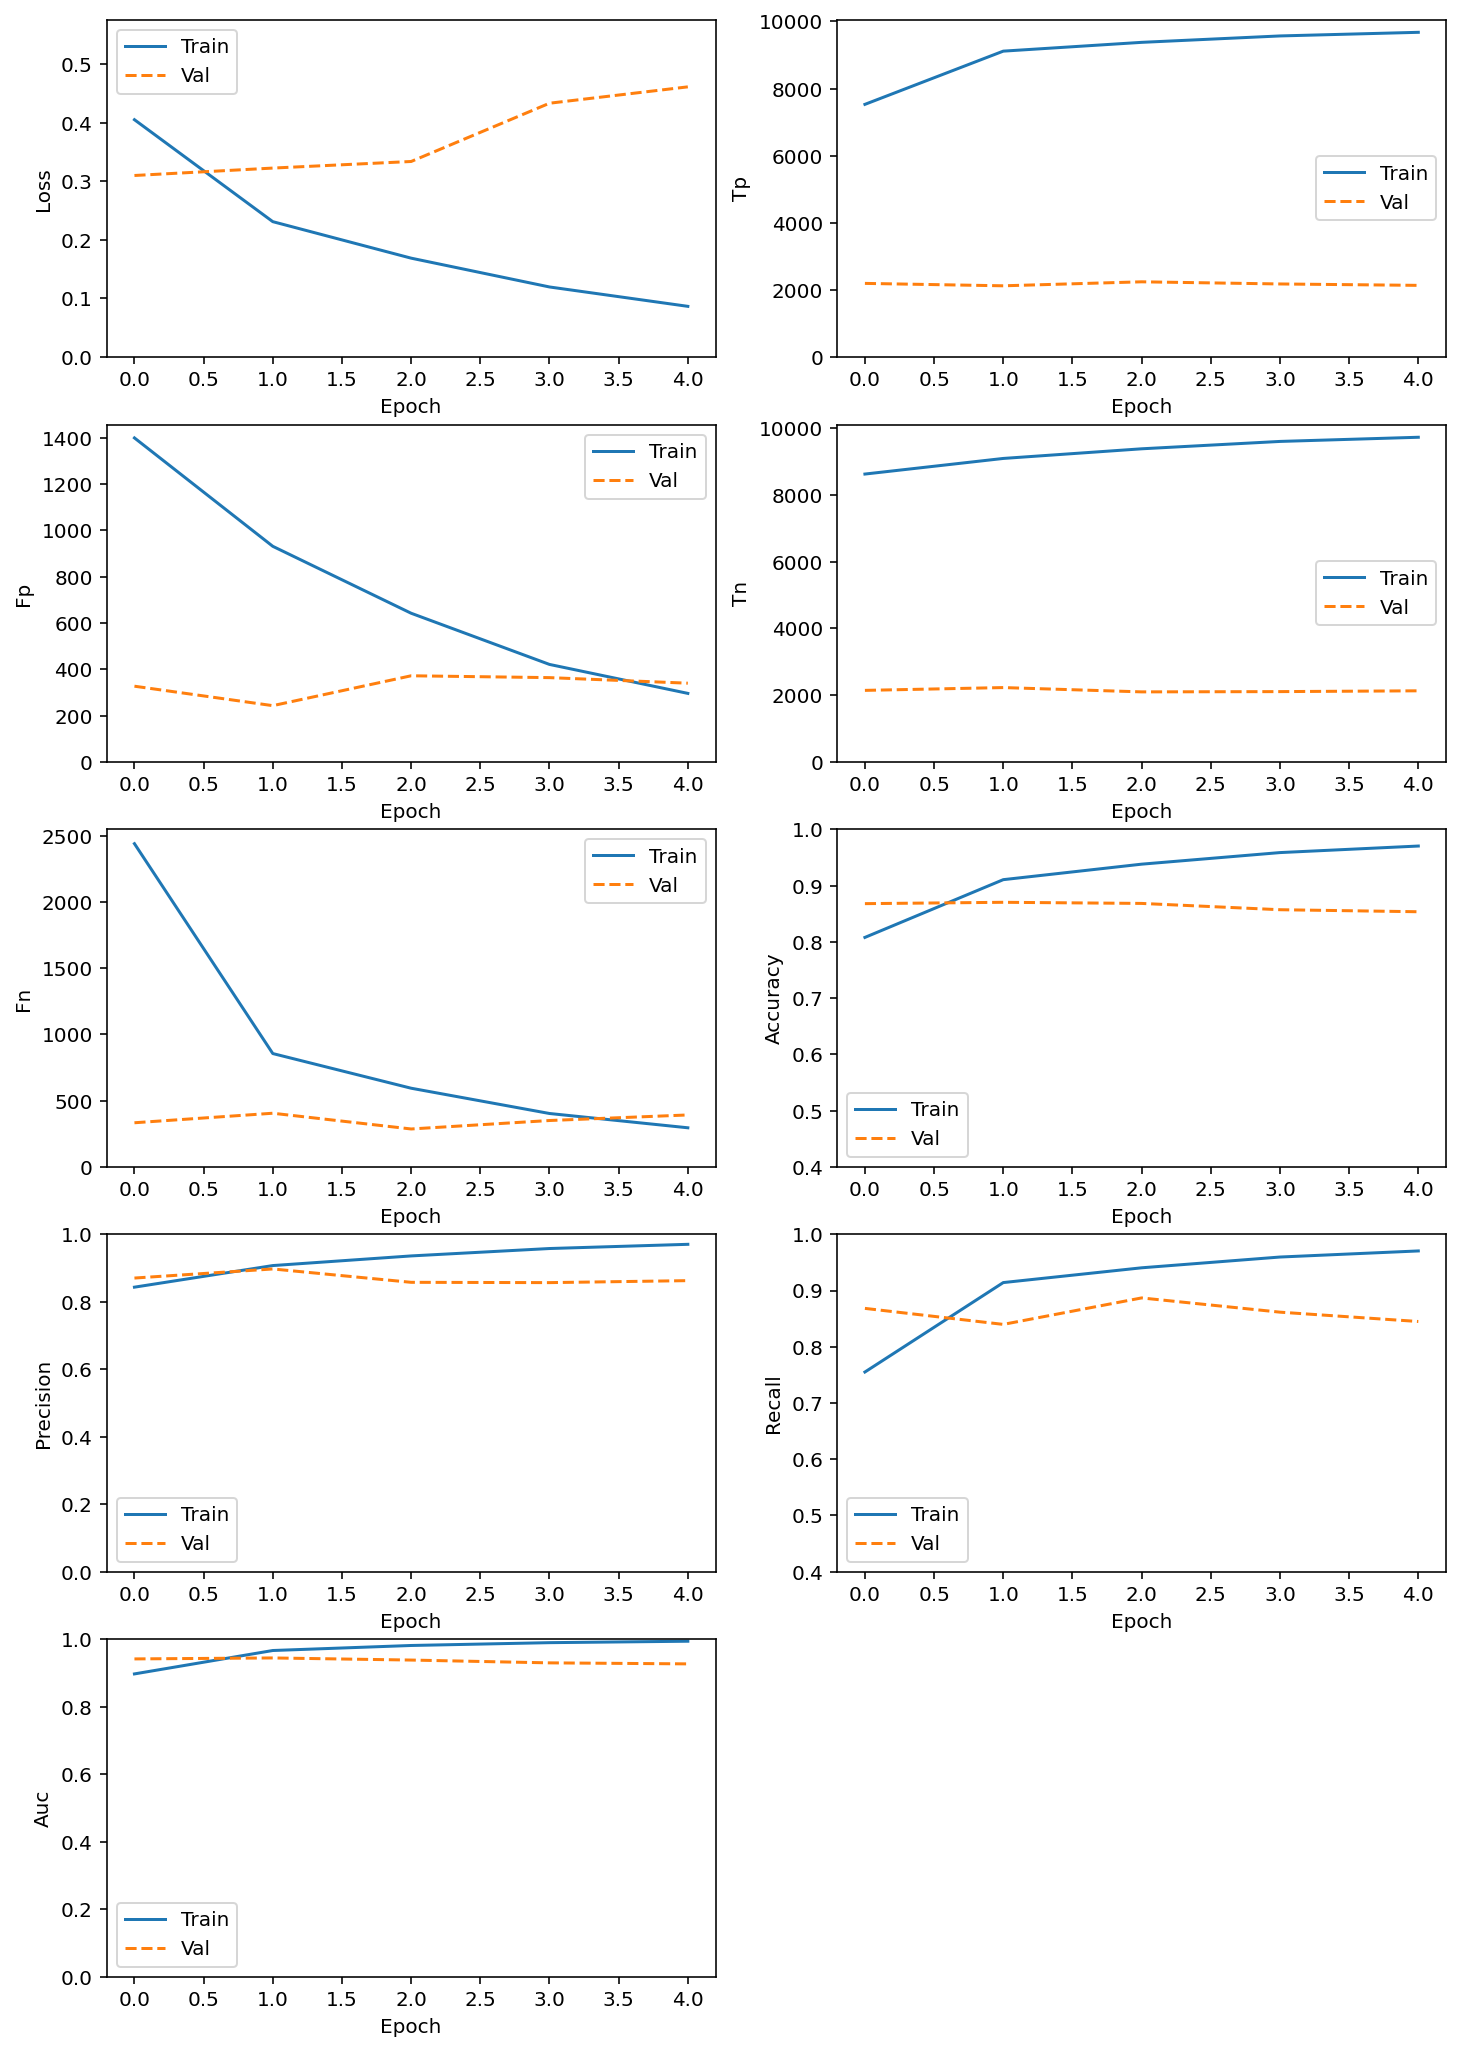

In [25]:
# Cross Validation Classification Accuracy
  
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams["figure.figsize"] = (12, 18)
  
def plot_metrics(history):
    metrics = [
        "loss",
        "tp", "fp", "tn", "fn",
        "accuracy",
        "precision", "recall",
        "auc",
    ]
    for n, metric in  enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(5, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1] * 1.2])
        elif metric == "accuracy":
            plt.ylim([0.4, 1])
        elif metric == "fn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "fp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "precision":
            plt.ylim([0, 1])
        elif metric == "recall":
            plt.ylim([0.4, 1])
        else:
            plt.ylim([0, 1])
          
        plt.legend()
  
plot_metrics(history)

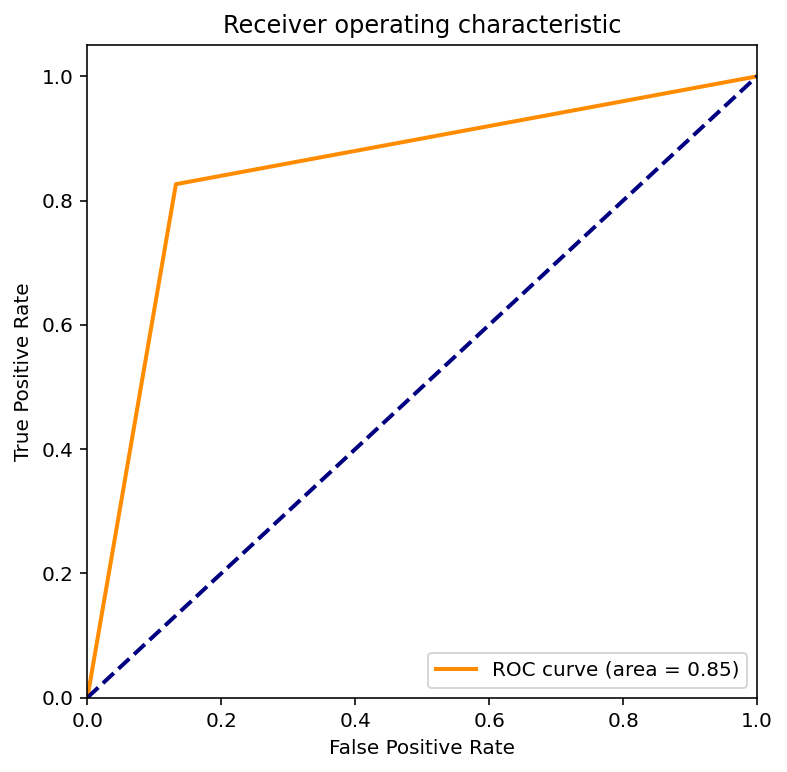

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
  
mpl.rcParams["figure.figsize"] = (6, 6)
  
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score
  
# Binarize the output
y_bin = label_binarize(y_test, classes=[0, 1])
n_classes = 1
  
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in  range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])
  
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()